This notebook is motivated by the paper, [A Systematic Approach for Variable Selection
With Random Forests: Achieving Stable
Variable Importance Values](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8038868).  

# Plan
Basically, I want to replicate this paper, but with many more data sets, exploring their ideas more fully.  For example,
they talk about how the degree of class separability affects how large a forest must be to stabilize feature
importances.  They define "separability" by the accuracy that was achieved in a given data set in a prior study.  With this
in mind, I want to better define "separability" so it extends a little better to imbalanced data sets; I will do this
using "balanced accuracy."  Secondly, I want to show that though "separability" may have appeared to be a strong
driver of a stabilization approach in their paper, I think this is because they looked at only two data sets.  The first thing
I found when playing around with this stuff is that (i) the mushroom data set is perfectly predictable (acc = bAcc = 1), and
(ii) it does not seem (even w/ a 10k-tree forest) that all feature importances every truly stabilize.  For example, some of
them have a "strong preference" of ranking, but will occasionally flip to a much different ranking -- usually the same 2-3
rankings.  This behavior is likely due to correlated predictors, and some feature importance measures will be more or 
less affected by this... The major point is that the idea of a "true ranking" might not necessarily be true.  I am also
interested in modifying their definition: they compute the running average of a feature's rank over a sequence of
training iterations ("retrains"); while this quantity often does converge, there are several issues I've noticed: 

(i) The "avg rank" sometimes converges to a rank the feature never acquired (e.g., a feature that appears to be rank 
2 most often, but occasionally flips to rank 45, might converge to an "average rank" value between 8-9).  This is surely
not what we want: if the variable is rank 2 85% and only rank 45 15% of the time, then do we really want to consider
it of rank 9?  Using the ranks in each retrain, it is hard to fix this: a median or mode rank is likely not to be unique
and perhaps be less informative than "average rank".  This leads us to the next observation.


(ii) Taking the "average rank" instead of the "average importance" distorts the truth quite a bit.  For example, consider
the variable above that is often ranked as 2, but occasionally as 45.  Imagine there are about 100 features here, so
that by the time it gets to rank 45, the distances between ranks are orders of magnitude smaller than the distances
between ranks in the top 10.  In other words, in this case, it is much less important that the variable occasionally
took on rank 45, as opposed to say rank 43 or rank 47, than "average rank" would have you believe.  It is likely
a better measure to take the average of "feature importance" or the median.


Ultimately, I want to look at how ranks stabilize in a classification problem, then in a regression problem.


# Classification Data Sets
The first data set we will play with is the UCI Mushroom data set.  It's simple and super easy to predict on.

We will also look at various health-related and miscellaneous data sets from the UCI repository.

I've listed many data sets [here](https://krbnite.github.io/Experimenting-with-Random-Forests-on-UCI-ML-Data-Sets/).  My
advice is to pick 4-5, do a write-up, then think about doing another write-up.  


In the main paper, they talk as if feature stability isn't really considered in the literature.  In my experience
as well, most casual machine learning folk do not seem to question how robust a feature selection/ranking is...  However,
there is actually quite a bit in the literature about feature selection stability/robustness:
* 2008: Saeys et al: [Robust Feature Selection Using Ensemble Feature Selection Techniques](https://link.springer.com/content/pdf/10.1007/978-3-540-87481-2_21.pdf)
* 2005: Kalousis et al: [Stability of Feature Selection Algorithms](https://www.researchgate.net/profile/Alexandros_Kalousis/publication/4207687_Stability_of_feature_selection_algorithms/links/0fcfd50abb62563e08000000/Stability-of-feature-selection-algorithms.pdf)
* 2007: Kalousis et al: [Stability of feature selection algorithms: a study on high-dimensional spaces](http://doc.rero.ch/record/312354/files/10115_2006_Article_40.pdf)
* 2011: Toloşi & Lengauer: [Classification with correlated features: unreliability of feature ranking and solutions](https://academic.oup.com/bioinformatics/article/27/14/1986/194387)

I think what's key to their paper is that they explicitly focus on random forests, and how nTree affects the GImp and PImp
stabilities.  They also attempt to link this stability/robustness to the degree to which a dataset's classes are
separable.  However, I show below that for high-dimensional feature spaces, that doesn't necessarily hold up: correlations
between features seem to be the thing that really destablize rankings.


The instability of features is often a concern with microarray data (though the authors who point this out also
note that many studies don't pay heed to this):
* 2014: Kursa: [Robustness of Random Forest-based gene selection methods](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-15-8)
* 2016: Wang et al: [An experimental study of the intrinsic stability of random forest variable importance measures](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-016-0900-5)

## Parkinson's Data
Since (i) we are tangentially interest in Parksinson's, (ii) there exist several Parkinson's
classification data sets in the UCI ML repository, and (iii) I do not see much about this topic
in a quick Google Scholar search for the Parkinson's area, I think the first paper can be something there...  
* Turn this mushroom stuff into a blog post
* Then perform similar analyses on the following PD data sets

Data Sets
* [Parkinsons](https://archive.ics.uci.edu/ml/datasets/Parkinsons)
* [Parkinson Speech Dataset with Multiple Types of Sound Recordings](https://archive.ics.uci.edu/ml/datasets/Parkinson+Speech+Dataset+with++Multiple+Types+of+Sound+Recordings)
* [Parkinson Disease Spiral Drawings Using Digitized Graphics Tablet](https://archive.ics.uci.edu/ml/datasets/Parkinson+Disease+Spiral+Drawings+Using+Digitized+Graphics+Tablet)
* [Parkinson's Disease Classification](https://archive.ics.uci.edu/ml/datasets/Parkinson%27s+Disease+Classification)
* [Parkinson Dataset with replicated acoustic features](https://archive.ics.uci.edu/ml/datasets/Parkinson+Dataset+with+replicated+acoustic+features+)



NOTE TO SELF: Remember, you converted importance values to rankings incorrectly!  You need to do
a reverse sorting of the importance values.

In [10]:
# Get Table Data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.names
# Get Table MetaData
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data
# Extract Feature Names 
!cat agaricus-lepiota.names | grep "^[[:space:]]\{4,5\}[0-9]\{1,2\}.*:" > agaricus-lepiota-feature-names.txt
# Move to _data folder (put _data in .gitignore file)
!mv agaricus* _data/

--2019-09-22 23:43:22--  https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.names
Resolving archive.ics.uci.edu... 128.195.10.252
Connecting to archive.ics.uci.edu|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6816 (6.7K) [application/x-httpd-php]
Saving to: 'agaricus-lepiota.names'

agaricus-lepiota.na 100%[===================>]   6.66K  --.-KB/s    in 0s      

2019-09-22 23:43:24 (43.0 MB/s) - 'agaricus-lepiota.names' saved [6816/6816]

--2019-09-22 23:43:24--  https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data
Resolving archive.ics.uci.edu... 128.195.10.252
Connecting to archive.ics.uci.edu|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 373704 (365K) [application/x-httpd-php]
Saving to: 'agaricus-lepiota.data'

agaricus-lepiota.da 100%[===================>] 364.95K   708KB/s    in 0.5s    

2019-09-22 23:43:25 (708 KB/s) - 'agar

I've worked with the UCI ML repository's mushroom data set [before](https://krbnite.github.io/Treebeard-and-the-Fungus-Amongus/), and I shamelessly borrow my code from there to import, transform, and split 
the data.

# Load Some Code

In [141]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import feature_selection as filt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# Import Data

In [2]:
# Extract features names
with open('_data/agaricus-lepiota-feature-names.txt') as f:
    features = [line.split()[1][0:-1] for line in f]
    
# Get Data
data = pd.read_csv('_data/agaricus-lepiota.data', names=['deadly']+features)
y = pd.DataFrame([1 if target=='p' else 0 for target in data['deadly']], columns=['deadly'])
x = data.drop('deadly', axis=1)

# Split the Data

In [16]:
# Train, Validate, Test
x_trn, x_vt, y_trn, y_vt = train_test_split(x, y, train_size=0.70)
x_val, x_tst, y_val, y_tst = train_test_split(x_vt, y_vt, test_size=0.50)

# Some/Most techniques require the categorical vars to be one-hot encoded
x_trn_ohe = pd.get_dummies(x_trn)
x_val_ohe = pd.get_dummies(x_val)
x_tst_ohe = pd.get_dummies(x_tst)

# Make sure the various dummy vars are represented in each subset
all_ftrs = pd.get_dummies(x).columns
for ftr in all_ftrs.difference(x_trn_code.columns): x_trn_ohe[ftr]=0
for ftr in all_ftrs.difference(x_val_code.columns): x_val_ohe[ftr]=0
for ftr in all_ftrs.difference(x_tst_code.columns): x_tst_ohe[ftr]=0

/Users/kevinurban/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In the Behnamian paper, they do not toggle many hyperparameters:
* Leave mtry as default (sqrt(F))
* If you choose some kind of additional constraints, keep them fixed for all runs

Importantly, the authors looked at how many training iterations ("retrains" henceforth) it took 
for the average variable importance rankings to stabilize given RFs with 50, 200, 500, and 10k 
trees.  For each RF, they ran 25 retrains.

They looked at both Gini important (aka mean decrease in Gini impurity, MDG) and permutation
important (aka mean decrease in accuracy, MDA).

Basically, they look at sequences like
$$\{\overline{VI}_{p,nTree}(i)\}_{i=1}^{25}$$

where p is a fixed predictor, nTree is a fixed forest size, and the 
ith term is defined as

$$\overline{VI}_{p,nTree}(i) = \frac{1}{i}\sum\limits_{j=1}^{i}{VI_{p,nTree}(j)}$$

Plotting this sequence for a fixed predictor and forest size can shed light on how many
runs one should do to stabilize the variable importances.  Better, one might create a 
"spaghetti plot" of these sequences for, say, the top 10 predictors from the first training
iteration, then look to see when they all stop criss-crossing and seem to settle to a fixed
value.  

To have an aggregate indicator of stabilization over all predictors, the authors concocted
a distance metric:

$$D(i) = \sqrt{\frac{\sum_{p=1}^{P}(\overline{VI}_{p,nTree}(i) - \overline{VI}_{p,nTree}(25))^{2}}{P}}$$

This serves as an average "distance from the true mean" over all predictors, where the "true mean"
is assumed to be well approximated by the average over 25 retrains.

Their major finding was that a 10k-tree forest basically only needs one training iteration for
variable importance covergence, but that it is computationally burdensome compared to averaging, say,
the variable importances of a 50-tree forest over 21 retrains.  They quoted the timings for 
their data set, showing that the 10k-tree forest took 10x as long to train than the smaller 
forest over 21 retains.  

This is interesting because it really calls into question what you want to do
and which forest is best.  I've seen prediction accuracy stabilize at 50-100 trees,
while variable importances fluctuate like crazy from one training iteration to the
next w/ no change in hyperparameters.  This tells you that there are many ways to
skin a cat (that is, many ways to effectively separate classes), but that for a 
given predictor set you might imagine there is one "true way".  In the "true way" sense,
it "feels" like we should want to 10k-tree forest, but from a predictive accuracy, training
time, and prediction time sense, it is better to go with a smaller forest.  Maybe the best
of both worlds is finding the "true rankings", cutting the worst performers while maintaining
the same level of accuracy, then using as big a forest as convenient for the final forest.

For example, say you start with 100 predictors.  You find the true rankings using 30 retrains
of a fairly small forest.  Then you cut predictors from the bottom until the accuracy starts
to change.  Say after this, you have 35 predictors left.  At this point, opt for a slightly
bigger forest than you initially would have (e.g., with 100 predictors, you might have preferred
a 1k-tree forest, but could only afford a 500-tree forest in memory; well, go ahead and see
if you can afford that 1k-tree forest now, baby!).


### Separability
The authors define separability by a model's accuracy: a 7-class data set that was previously reported to 
have been predicted with 84% accuracy was selected to represent "good separability," whereas a 5-class data
set previously reported to be predicted with 63% accuracy was defined as having "poor separability."  Without
looking into the previous papers, it's not clear weather these were balanced or imbalanced data sets, but
it's likely to more generally define this separability by something like "balanced accuracy."  This is important
since many data sets are highly imbalanced, e.g., for a 2-class data set where the minority class makes up 1%,
a 99% accuracy can be achieved by simply guessing the majority class for everything, and this clearly doesn't
represent "good separability" in any meaningful way.

* 2010: Brodersen:  [The Balanced Accuracy and Its Posterior Distribution](https://ieeexplore.ieee.org/document/5597285) ([pdf](https://ong-home.my/papers/brodersen10post-balacc.pdf)).

For each model we look at, we will use the median and/or best balanced accuracy found to qualitatively
define class separability within a data set.

The mushrooms data set has extremely good separability: our simplest forests below are able to get perfect
predictions.  Yet it isn't until we get to 10k-tree forests that the GImp starts to stabilize.  

# Replication Bit
First, using the mushrooms data set, I will basically replicate what the authors did: look at 25 training iterations
for 50-tree, 200-tree, 500-tree, and 10k-tree forests.  

We will build a DataFrame, rfx_ranks, that has a ......

In [93]:
n_ftrs = len(x_trn_ohe.columns)

In [64]:
rf50 = dict()
rf50_ranks = pd.DataFrame(columns = x_trn_ohe.columns)
rf50_avg = pd.DataFrame(columns = x_trn_ohe.columns)
for i in range(25): 
    rf50[i] = RandomForestClassifier(n_estimators=50)
    rf50[i].fit(x_trn_ohe,y_trn.values.ravel())
    rf50_ranks.loc[i] = np.argsort(rf50[i].feature_importances_)
    rf50_avg.loc[i] = rf50_ranks.mean()

In [107]:
rf50_ba = pd.DataFrame(columns=['balanced_accuracy'])
for i in range(25): 
    y_pred = rf50[i].predict(x_val_ohe)
    rf50_ba.loc[i] = metrics.balanced_accuracy_score(y_val, y_pred)

In [94]:
d50 = np.sum(np.square(rf50_avg - rf50_avg.loc[24]), axis=1)/n_ftrs

In [65]:
rf50_ranks

,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,82,64,84,99,17,104,43,103,1,67,...,102,51,37,57,61,36,96,24,35,27
1,82,103,38,95,76,75,99,1,79,44,...,21,36,20,94,57,35,37,61,24,27
2,72,43,64,82,99,103,73,1,41,48,...,108,94,36,21,35,61,96,37,24,27
3,95,1,43,103,84,82,99,64,12,38,...,58,61,94,37,96,36,35,57,24,27
4,43,83,82,95,99,103,104,17,84,66,...,61,94,57,37,36,20,96,35,24,27
5,116,1,64,43,78,82,83,95,104,99,...,94,96,20,108,61,57,36,35,24,27
6,43,84,103,16,82,99,95,83,1,66,...,21,94,20,96,36,24,61,37,35,27
7,82,83,99,78,66,31,95,103,43,75,...,21,58,57,35,96,92,37,24,36,27
8,67,82,83,84,95,99,103,17,16,85,...,62,20,61,37,36,57,94,35,24,27
9,83,82,78,99,68,103,95,43,12,1,...,21,108,96,35,37,94,61,36,24,27


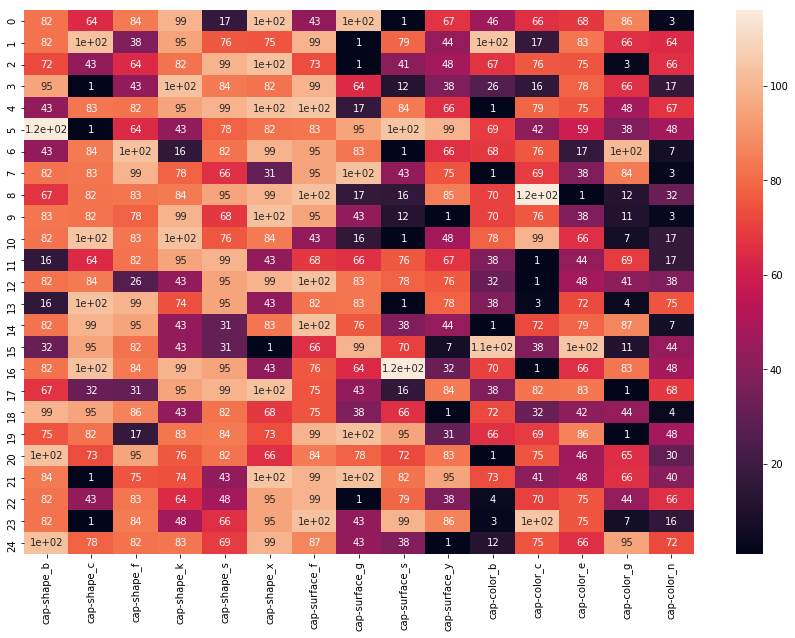

In [161]:
plt.figure(figsize=(15,10))
sns.heatmap(rf50_ranks.astype(np.float32).iloc[:,0:15], annot=True)

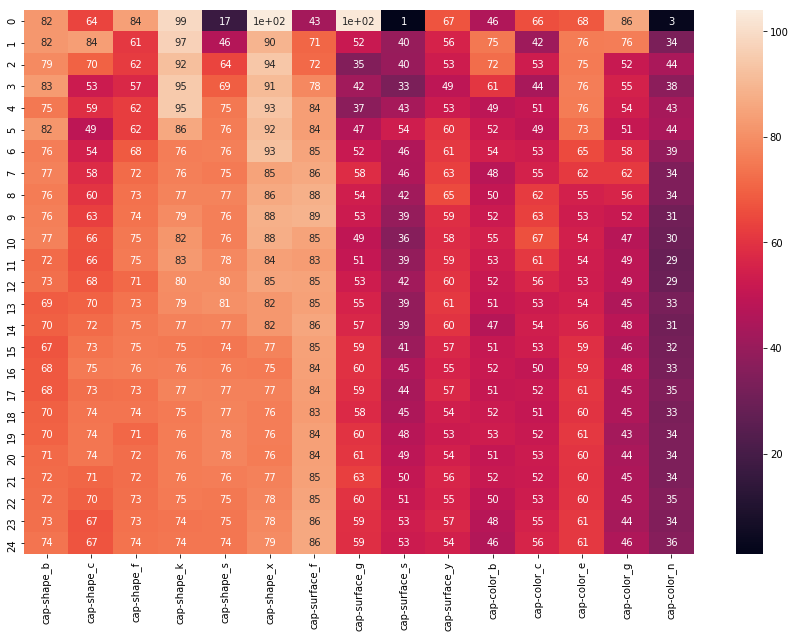

In [162]:
plt.figure(figsize=(15,10))
sns.heatmap(rf50_avg.iloc[:,0:15], annot=True)

In [66]:
rf50_ranks['cap-shape_b'].hist(bin)

,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,82.000000,64.000000,84.000000,99.000000,17.000000,104.000000,43.000000,103.000000,1.000000,67.000000,...,102.000000,51.000000,37.000000,57.000000,61.000000,36.000000,96.000000,24.000000,35.000000,27.0
1,82.000000,83.500000,61.000000,97.000000,46.500000,89.500000,71.000000,52.000000,40.000000,55.500000,...,61.500000,43.500000,28.500000,75.500000,59.000000,35.500000,66.500000,42.500000,29.500000,27.0
2,78.666667,70.000000,62.000000,92.000000,64.000000,94.000000,71.666667,35.000000,40.333333,53.000000,...,77.000000,60.333333,31.000000,57.333333,51.000000,44.000000,76.333333,40.666667,27.666667,27.0
3,82.750000,52.750000,57.250000,94.750000,69.000000,91.000000,78.500000,42.250000,33.250000,49.250000,...,72.250000,60.500000,46.750000,52.250000,62.250000,42.000000,66.000000,44.750000,26.750000,27.0
4,74.800000,58.800000,62.200000,94.800000,75.000000,93.400000,83.600000,37.200000,43.400000,52.600000,...,70.000000,67.200000,48.800000,49.200000,57.000000,37.600000,72.000000,42.800000,26.200000,27.0
5,81.666667,49.166667,62.500000,86.166667,75.500000,91.500000,83.500000,46.833333,53.500000,60.333333,...,74.000000,72.000000,44.000000,59.000000,57.666667,40.833333,66.000000,41.500000,25.833333,27.0
6,76.142857,54.142857,68.285714,76.142857,76.428571,92.571429,85.142857,52.000000,46.000000,61.142857,...,66.428571,75.142857,40.571429,64.285714,54.571429,38.428571,65.285714,40.857143,27.142857,27.0
7,76.875000,57.750000,72.125000,76.375000,75.125000,84.875000,86.375000,58.375000,45.625000,62.875000,...,60.750000,73.000000,42.625000,60.625000,59.750000,45.125000,61.750000,38.750000,28.250000,27.0
8,75.777778,60.444444,73.333333,77.222222,77.333333,86.444444,88.222222,53.777778,42.333333,65.333333,...,60.888889,67.111111,44.666667,58.000000,57.111111,46.444444,65.333333,38.333333,27.777778,27.0
9,76.500000,62.600000,73.800000,79.400000,76.400000,88.100000,88.900000,52.700000,39.300000,58.900000,...,56.900000,71.200000,49.800000,55.700000,55.100000,51.200000,64.900000,38.100000,27.400000,27.0


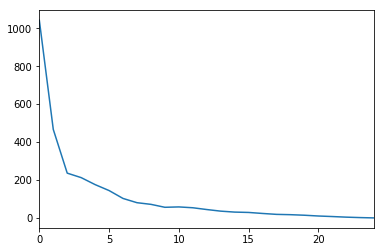

In [96]:
d50.plot()

In [108]:
rf50_ba

,balanced_accuracy
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0


In [67]:
rf200 = dict()
rf200_ranks = pd.DataFrame(columns = x_trn_ohe.columns)
rf200_avg = pd.DataFrame(columns = x_trn_ohe.columns)
for i in range(25): 
    rf200[i] = RandomForestClassifier(n_estimators=200)
    rf200[i].fit(x_trn_ohe,y_trn.values.ravel())
    rf200_ranks.loc[i] = np.argsort(rf200[i].feature_importances_)
    rf200_avg.loc[i] = rf200_ranks.mean()

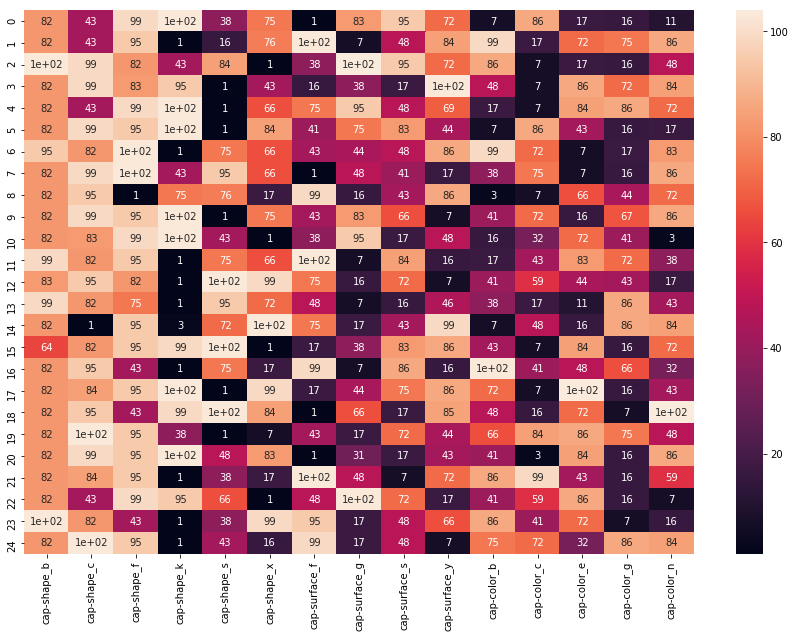

In [163]:
plt.figure(figsize=(15,10))
sns.heatmap(rf200_ranks.astype(np.float32).iloc[:,0:15], annot=True)

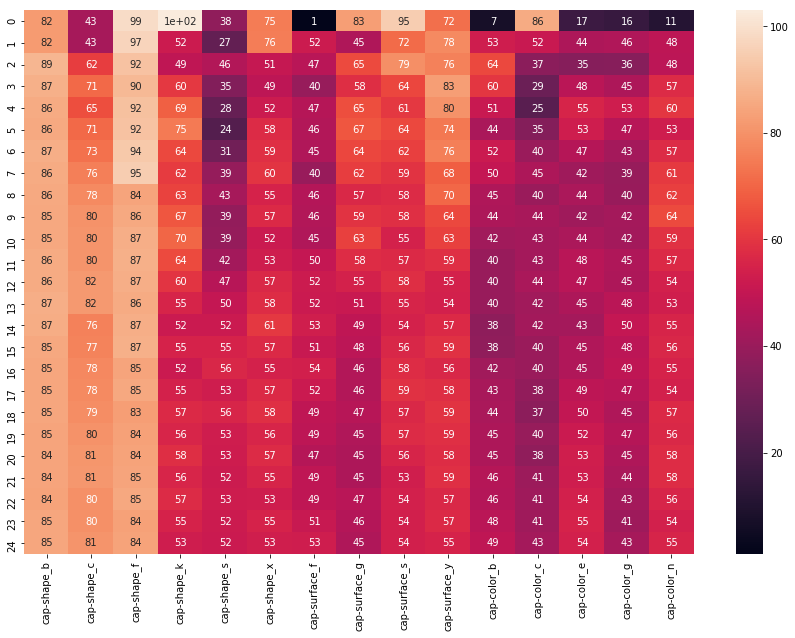

In [164]:
plt.figure(figsize=(15,10))
sns.heatmap(rf200_avg.iloc[:,0:15], annot=True)

In [70]:
rf200_ranks

,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,82,43,99,103,38,75,1,83,95,72,...,20,94,37,57,96,61,36,35,24,27
1,82,43,95,1,16,76,103,7,48,84,...,20,94,57,37,61,24,36,96,35,27
2,103,99,82,43,84,1,38,104,95,72,...,20,94,96,37,57,61,24,35,36,27
3,82,99,83,95,1,43,16,38,17,103,...,21,61,37,94,96,57,36,35,24,27
4,82,43,99,103,1,66,75,95,48,69,...,108,94,61,37,96,57,36,35,24,27
5,82,99,95,103,1,84,41,75,83,44,...,61,20,94,57,37,96,35,24,36,27
6,95,82,103,1,75,66,43,44,48,86,...,108,21,57,61,35,37,96,36,24,27
7,82,99,103,43,95,66,1,48,41,17,...,20,21,61,37,57,35,96,24,36,27
8,82,95,1,75,76,17,99,16,43,86,...,108,37,57,94,96,61,36,24,35,27
9,82,99,95,103,1,75,43,83,66,7,...,21,58,37,61,96,57,35,36,24,27


In [71]:
rf200_avg

,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,82.000000,43.000000,99.000000,103.000000,38.000000,75.000000,1.000000,83.000000,95.000000,72.000000,...,20.000000,94.000000,37.000000,57.000000,96.000000,61.000000,36.000000,35.000000,24.000000,27.0
1,82.000000,43.000000,97.000000,52.000000,27.000000,75.500000,52.000000,45.000000,71.500000,78.000000,...,20.000000,94.000000,47.000000,47.000000,78.500000,42.500000,36.000000,65.500000,29.500000,27.0
2,89.000000,61.666667,92.000000,49.000000,46.000000,50.666667,47.333333,64.666667,79.333333,76.000000,...,20.000000,94.000000,63.333333,43.666667,71.333333,48.666667,32.000000,55.333333,31.666667,27.0
3,87.250000,71.000000,89.750000,60.500000,34.750000,48.750000,39.500000,58.000000,63.750000,82.750000,...,20.250000,85.750000,56.750000,56.250000,77.500000,50.750000,33.000000,50.250000,29.750000,27.0
4,86.200000,65.400000,91.600000,69.000000,28.000000,52.200000,46.600000,65.400000,60.600000,80.000000,...,37.800000,87.400000,57.600000,52.400000,81.200000,52.000000,33.600000,47.200000,28.600000,27.0
5,85.500000,71.000000,92.166667,74.666667,23.500000,57.500000,45.666667,67.000000,64.333333,74.000000,...,41.666667,76.166667,63.666667,53.166667,73.833333,59.333333,33.833333,43.333333,29.833333,27.0
6,86.857143,72.571429,93.714286,64.142857,30.857143,58.714286,45.285714,63.714286,62.000000,75.714286,...,51.142857,68.285714,62.714286,54.285714,68.285714,56.142857,42.714286,42.285714,29.000000,27.0
7,86.250000,75.875000,94.875000,61.500000,38.875000,59.625000,39.750000,61.750000,59.375000,68.375000,...,47.250000,62.375000,62.500000,52.125000,66.875000,53.500000,49.375000,40.000000,29.875000,27.0
8,85.777778,78.000000,84.444444,63.000000,43.000000,54.888889,46.333333,56.666667,57.555556,70.333333,...,54.000000,59.555556,61.888889,56.777778,70.111111,54.333333,47.888889,38.222222,30.444444,27.0
9,85.400000,80.100000,85.500000,67.000000,38.800000,56.900000,46.000000,59.300000,58.400000,64.000000,...,50.700000,59.400000,59.400000,57.200000,72.700000,54.600000,46.600000,38.000000,29.800000,27.0


In [100]:
d200 = np.sum(np.square(rf200_avg - rf200_avg.loc[24]), axis=1)/n_ftrs

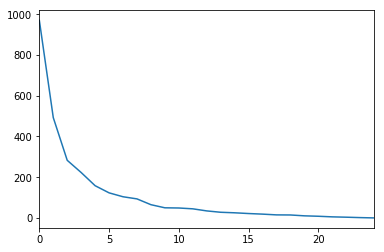

In [101]:
d200.plot()

In [72]:
rf500 = dict()
rf500_ranks = pd.DataFrame(columns = x_trn_ohe.columns)
rf500_avg = pd.DataFrame(columns = x_trn_ohe.columns)
for i in range(25): 
    rf500[i] = RandomForestClassifier(n_estimators=500)
    rf500[i].fit(x_trn_ohe,y_trn.values.ravel())
    rf500_ranks.loc[i] = np.argsort(rf500[i].feature_importances_)
    rf500_avg.loc[i] = rf500_ranks.mean()

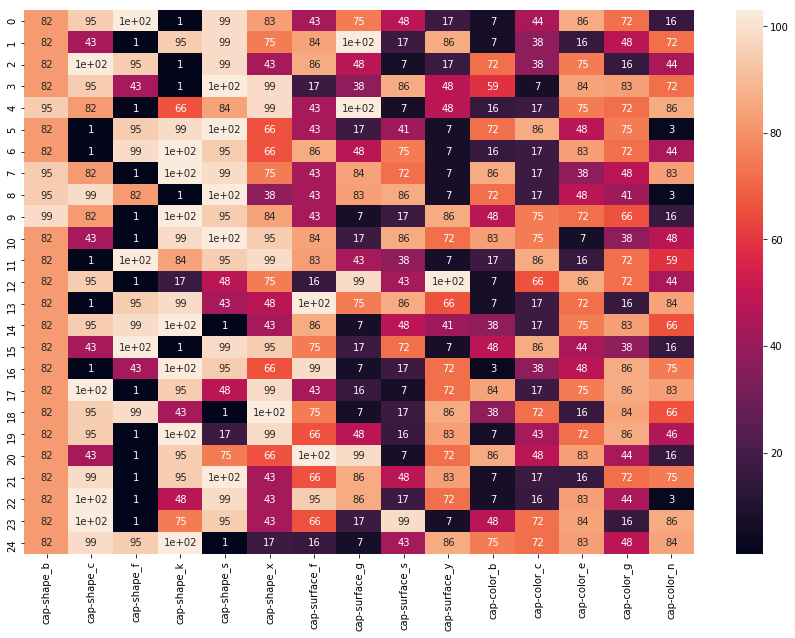

In [165]:
plt.figure(figsize=(15,10))
sns.heatmap(rf500_ranks.astype(np.float32).iloc[:,0:15], annot=True)

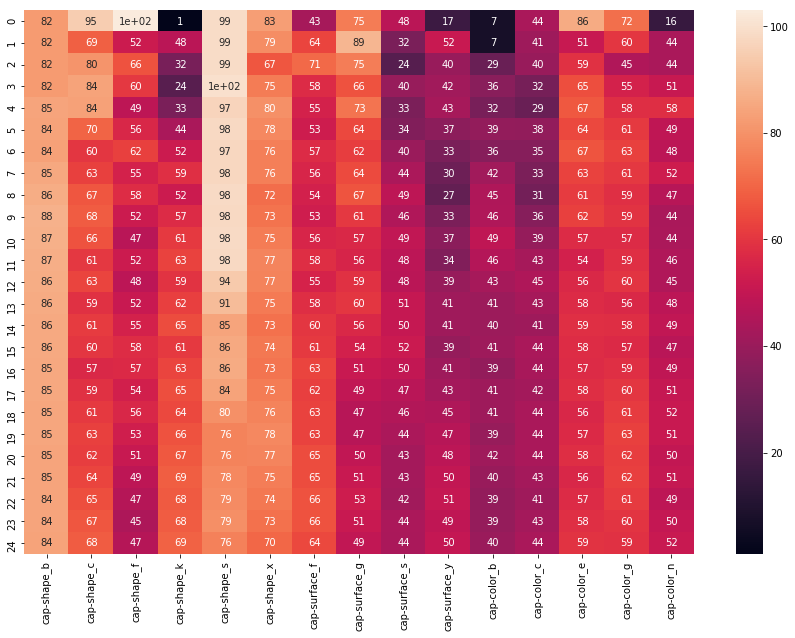

In [166]:
plt.figure(figsize=(15,10))
sns.heatmap(rf500_avg.iloc[:,0:15], annot=True)

In [75]:
rf500_ranks

,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,82,95,103,1,99,83,43,75,48,17,...,21,94,61,96,37,57,35,36,24,27
1,82,43,1,95,99,75,84,103,17,86,...,21,37,61,94,96,57,35,36,24,27
2,82,103,95,1,99,43,86,48,7,17,...,21,94,61,57,37,96,35,24,36,27
3,82,95,43,1,103,99,17,38,86,48,...,21,57,94,61,37,96,24,35,36,27
4,95,82,1,66,84,99,43,103,7,48,...,108,94,37,61,96,57,35,36,24,27
5,82,1,95,99,103,66,43,17,41,7,...,21,61,37,57,94,96,35,24,36,27
6,82,1,99,103,95,66,86,48,75,7,...,21,94,96,37,61,57,35,24,36,27
7,95,82,1,103,99,75,43,84,72,7,...,20,94,61,37,57,96,36,35,24,27
8,95,99,82,1,103,38,43,83,86,7,...,108,94,37,61,57,96,35,36,24,27
9,99,82,1,103,95,84,43,7,17,86,...,21,94,96,61,37,57,35,36,24,27


In [76]:
rf500_avg

,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,82.000000,95.000000,103.000000,1.000000,99.000000,83.000000,43.000000,75.000000,48.000000,17.000000,...,21.000000,94.000000,61.000000,96.000000,37.000000,57.000000,35.000000,36.000000,24.000000,27.0
1,82.000000,69.000000,52.000000,48.000000,99.000000,79.000000,63.500000,89.000000,32.500000,51.500000,...,21.000000,65.500000,61.000000,95.000000,66.500000,57.000000,35.000000,36.000000,24.000000,27.0
2,82.000000,80.333333,66.333333,32.333333,99.000000,67.000000,71.000000,75.333333,24.000000,40.000000,...,21.000000,75.000000,61.000000,82.333333,56.666667,70.000000,35.000000,32.000000,28.000000,27.0
3,82.000000,84.000000,60.500000,24.500000,100.000000,75.000000,57.500000,66.000000,39.500000,42.000000,...,21.000000,70.500000,69.250000,77.000000,51.750000,76.500000,32.250000,32.750000,30.000000,27.0
4,84.600000,83.600000,48.600000,32.800000,96.800000,79.800000,54.600000,73.400000,33.000000,43.200000,...,38.400000,75.200000,62.800000,73.800000,60.600000,72.600000,32.800000,33.400000,28.800000,27.0
5,84.166667,69.833333,56.333333,43.833333,97.833333,77.500000,52.666667,64.000000,34.333333,37.166667,...,35.500000,72.833333,58.500000,71.000000,66.166667,76.500000,33.166667,31.833333,30.000000,27.0
6,83.857143,60.000000,62.428571,52.285714,97.428571,75.857143,57.428571,61.714286,40.142857,32.857143,...,33.428571,75.857143,63.857143,66.142857,65.428571,73.714286,33.428571,30.714286,30.857143,27.0
7,85.250000,62.750000,54.750000,58.625000,97.625000,75.750000,55.625000,64.500000,44.125000,29.625000,...,31.750000,78.125000,63.500000,62.500000,64.375000,76.500000,33.750000,31.250000,30.000000,27.0
8,86.333333,66.777778,57.777778,52.222222,98.222222,71.555556,54.222222,66.555556,48.777778,27.111111,...,40.222222,79.888889,60.555556,62.333333,63.555556,78.666667,33.888889,31.777778,29.333333,27.0
9,87.600000,68.300000,52.100000,57.300000,97.900000,72.800000,53.100000,60.600000,45.600000,33.000000,...,38.300000,81.300000,64.100000,62.200000,60.900000,76.500000,34.000000,32.200000,28.800000,27.0


In [102]:
d500 = np.sum(np.square(rf500_avg - rf500_avg.loc[24]), axis=1)/n_ftrs

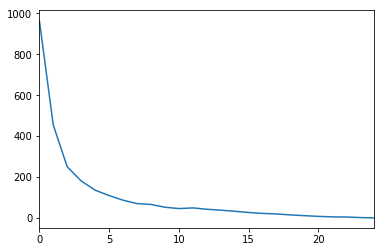

In [103]:
d500.plot()

In [77]:
rf10k = dict()
rf10k_ranks = pd.DataFrame(columns = x_trn_ohe.columns)
rf10k_avg = pd.DataFrame(columns = x_trn_ohe.columns)
for i in range(25): 
    rf10k[i] = RandomForestClassifier(n_estimators=10000)
    rf10k[i].fit(x_trn_ohe,y_trn.values.ravel())
    rf10k_ranks.loc[i] = np.argsort(rf10k[i].feature_importances_)
    rf10k_avg.loc[i] = rf10k_ranks.mean()

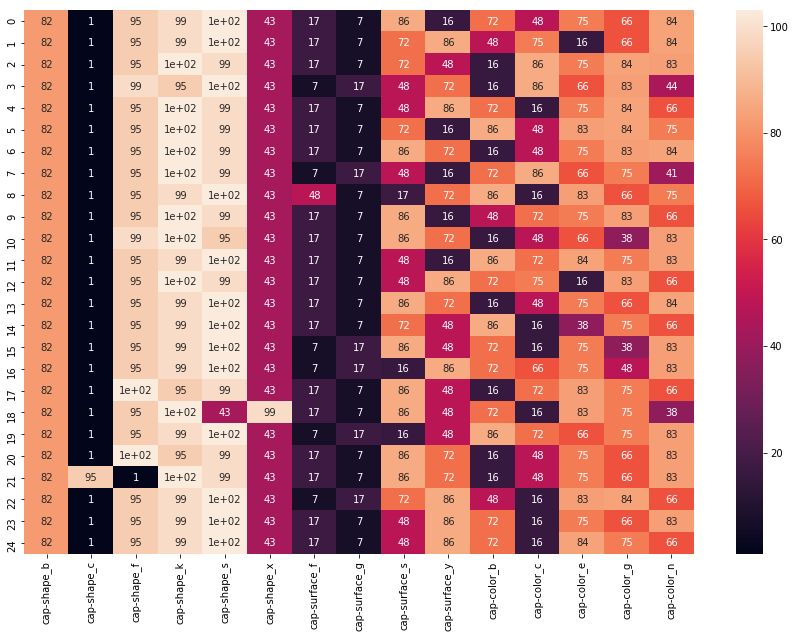

In [167]:
plt.figure(figsize=(15,10))
sns.heatmap(rf10k_ranks.astype(np.float32).iloc[:,0:15], annot=True)

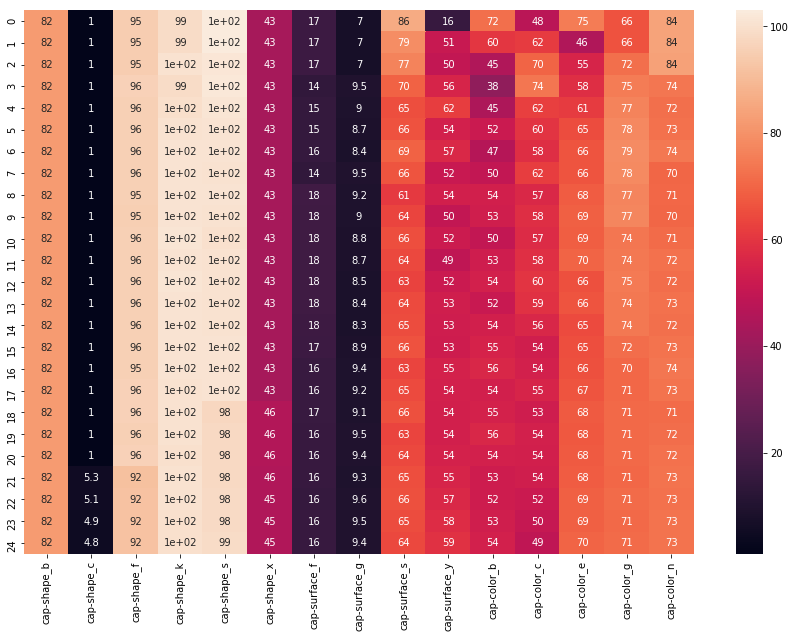

In [169]:
plt.figure(figsize=(15,10))
sns.heatmap(rf10k_avg.iloc[:,0:15], annot=True)

In [78]:
rf10k_ranks

,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,82,1,95,99,103,43,17,7,86,16,...,21,94,61,37,96,57,35,36,24,27
1,82,1,95,99,103,43,17,7,72,86,...,21,94,61,37,57,96,36,35,24,27
2,82,1,95,103,99,43,17,7,72,48,...,20,94,61,37,96,57,36,35,24,27
3,82,1,99,95,103,43,7,17,48,72,...,21,94,61,37,96,57,35,36,24,27
4,82,1,95,103,99,43,17,7,48,86,...,21,94,61,37,96,57,36,35,24,27
5,82,1,95,103,99,43,17,7,72,16,...,20,94,61,37,96,57,36,35,24,27
6,82,1,95,103,99,43,17,7,86,72,...,20,94,61,37,96,57,36,35,24,27
7,82,1,95,103,99,43,7,17,48,16,...,21,94,61,37,96,57,36,35,24,27
8,82,1,95,99,103,43,48,7,17,72,...,21,94,61,37,57,96,35,36,24,27
9,82,1,95,103,99,43,17,7,86,16,...,20,94,61,37,96,57,35,36,24,27


In [79]:
rf10k_avg

,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,82.0,1.000000,95.000000,99.000000,103.000000,43.000000,17.000000,7.000000,86.000000,16.000000,...,21.000000,94.0,61.000000,37.000000,96.000000,57.000000,35.000000,36.000000,24.0,27.0
1,82.0,1.000000,95.000000,99.000000,103.000000,43.000000,17.000000,7.000000,79.000000,51.000000,...,21.000000,94.0,61.000000,37.000000,76.500000,76.500000,35.500000,35.500000,24.0,27.0
2,82.0,1.000000,95.000000,100.333333,101.666667,43.000000,17.000000,7.000000,76.666667,50.000000,...,20.666667,94.0,61.000000,37.000000,83.000000,70.000000,35.666667,35.333333,24.0,27.0
3,82.0,1.000000,96.000000,99.000000,102.000000,43.000000,14.500000,9.500000,69.500000,55.500000,...,20.750000,94.0,61.000000,37.000000,86.250000,66.750000,35.500000,35.500000,24.0,27.0
4,82.0,1.000000,95.800000,99.800000,101.400000,43.000000,15.000000,9.000000,65.200000,61.600000,...,20.800000,94.0,61.000000,37.000000,88.200000,64.800000,35.600000,35.400000,24.0,27.0
5,82.0,1.000000,95.666667,100.333333,101.000000,43.000000,15.333333,8.666667,66.333333,54.000000,...,20.666667,94.0,61.000000,37.000000,89.500000,63.500000,35.666667,35.333333,24.0,27.0
6,82.0,1.000000,95.571429,100.714286,100.714286,43.000000,15.571429,8.428571,69.142857,56.571429,...,20.571429,94.0,61.000000,37.000000,90.428571,62.571429,35.714286,35.285714,24.0,27.0
7,82.0,1.000000,95.500000,101.000000,100.500000,43.000000,14.500000,9.500000,66.500000,51.500000,...,20.625000,94.0,61.000000,37.000000,91.125000,61.875000,35.750000,35.250000,24.0,27.0
8,82.0,1.000000,95.444444,100.777778,100.777778,43.000000,18.222222,9.222222,61.000000,53.777778,...,20.666667,94.0,61.000000,37.000000,87.333333,65.666667,35.666667,35.333333,24.0,27.0
9,82.0,1.000000,95.400000,101.000000,100.600000,43.000000,18.100000,9.000000,63.500000,50.000000,...,20.600000,94.0,61.000000,37.000000,88.200000,64.800000,35.600000,35.400000,24.0,27.0


In [104]:
d10k = np.sum(np.square(rf10k_avg - rf10k_avg.loc[24]), axis=1)/n_ftrs

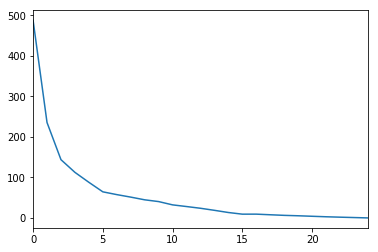

In [105]:
d10k.plot()